In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from lib.clue import Clue, DeductiveSolver
from lib.rl.episode import Episode, EpisodeCompletion
from lib.rl.ppo import PPOLoss
from lib.rl.recipe import ComponentConfig, TuneRecipeConfig
from lib.rl.trainer import Trainer
from lib.utils import return_exception
import torch
from torchtune.models.llama3_1 import llama3_1_8b
import random
import re


@return_exception
def sample_random_episode() -> Episode:
    game = Clue(
        num_players=3,
        elements={
            "suspect": random.sample(Clue.suspects, k=3),
            "weapon": random.sample(Clue.weapons, k=3),
            "room": random.sample(Clue.rooms, k=3),
            # "motive": random.sample(Clue.motives, k=3),
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        cp_solver_max_solve_time_per_turn=0.01,
        check_cp_solver_grid=False,
        check_if_deductive_solver_and_cp_solver_grids_match=False,
        print_playthrough=False,
    )
    prompt = game.get_prompt()
    follow_up = "Fill out your answer like this:\n" + "\n".join(
        f"{element.capitalize()}: <#{element.upper()}#>" for element in game.elements
    )

    async def reward_completion(completion: EpisodeCompletion) -> EpisodeCompletion:
        if len(completion.messages) == 2:
            follow_up_completion = await completion.follow_up(
                messages=[
                    {"role": "user", "content": follow_up},
                ]
            )
        else:
            follow_up_completion = completion
        answer = follow_up_completion.last_assistant_message.get("content")
        assert isinstance(answer, str)
        completion.reward = sum(
            [
                bool(
                    re.search(
                        f"{element}: {solution}",
                        answer,
                        re.IGNORECASE,
                    )
                )
                for element, solution in game.solution.items()
            ]
        ) / len(game.solution)
        return completion

    async def on_sample(completions: list[EpisodeCompletion]) -> None:
        for completion in await asyncio.gather(
            *[reward_completion(completion) for completion in completions]
        ):
            completion.commit()

    return Episode(
        messages=[{"role": "user", "content": prompt}],
        on_sample=on_sample,
    )


def train_episodes():
    while True:
        yield sample_random_episode()


trainer = Trainer(
    base_model="NousResearch/Hermes-2-Theta-Llama-3-8B",
    output_dir="./models/rl",
    samples_per_episode=8,
    branch_factor=2,
    train_episodes=train_episodes(),
    episodes_per_iteration=256,
    patience_per_sample=0.25,
    max_mask_sequence_batch_size=1,
    val_episodes=[sample_random_episode() for _ in range(256)],
    torchrun_kwargs=dict(nnodes=1, nproc_per_node=torch.cuda.device_count()),
    tune_model=llama3_1_8b,
    tune_model_type="LLAMA3",
    tune_recipe_config=TuneRecipeConfig(
        seed=42,
        shuffle=False,
        num_output_chunks=4,
        resume_from_checkpoint=False,
        batch_size=4,
        epochs=2,
        optimizer=ComponentConfig(
            "torch.optim.AdamW",
            # "bitsandbytes.optim.PagedAdamW8bit",
            # "bitsandbytes.optim.AdamW",
            # params=PLACEHOLDER,
            lr=5e-6,
            fused=True,
        ),
        loss=ComponentConfig(
            PPOLoss,
            clip_epsilon=0.3,
            entropy_coef=0.04,
            kl_coef=0.02,
            normalize_advantages=False,
        ),
        compile=False,
        optimizer_in_bwd=False,
        gradient_accumulation_steps=2,
        enable_activation_checkpointing=True,
        enable_activation_offloading=False,
        custom_sharded_layers=["tok_embeddings", "output"],
        log_every_n_steps=1,
        log_peak_memory_stats=True,
    ),
    tune_sequence_length=16384,
    vllm_env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    vllm_kwargs=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        max_model_len=16384,
        max_num_seqs=2048,
        max_num_batched_tokens=16384 * 4,
        # scheduling_policy="priority",
        # tensor_parallel_size=torch.cuda.device_count() // 8,
    ),
    vllm_max_concurrent_samples=2048,
    vllm_min_time_between_requests=0.0,
    vllm_num=8,
    vllm_timeout=90 + 30 * torch.cuda.device_count(),
)

INFO 11-27 02:25:38 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Theta-Llama-3-8B, num_scheduler_steps=1, chunked_prefill_enabled=Fal

In [12]:
trainer.max_mask_sequence_batch_size = 16
# (eval_score, eval_exceptions), 
result, = await asyncio.gather(
    # trainer.eval("val", 0, return_exceptions=True),
    trainer.explore(1, return_exceptions=True),
)
# print(f"Eval score: {eval_score:.2%}")
print(
    f"Generated {sum(completion.num_token_logprobs() for episode in result.episodes for completion in episode.completion.descendants()):,} tokens"
)
tensors = trainer.tensors(result.episodes)
(tensors["mask"] == result.tensors()["mask"]).all()

explore:   0%|          | 0/256 [00:00<?, ?episode/s]

Early stopping exploration due to expired patience (28.0 remaining samples x 0.25 patience per sample = 7.0 seconds)
Generated 538,429 tokens
Packed sequences in 0.22s ✓
Prepared tensors in 4.77s ✓
Created mask in 11.35s ✓


tensor(True)

In [9]:
tensors = trainer.tensors(result.episodes)
(tensors["mask"] == result.tensors()["mask"]).all()

Packed sequences in 0.23s ✓
Prepared tensors in 4.05s ✓
Created mask in 11.62s ✓


tensor(True)

In [23]:
torch.tensor(tensors["advantages"].shape).prod()

tensor(2113536)

In [10]:
tensors["mask"].shape

torch.Size([127, 16384, 16384])

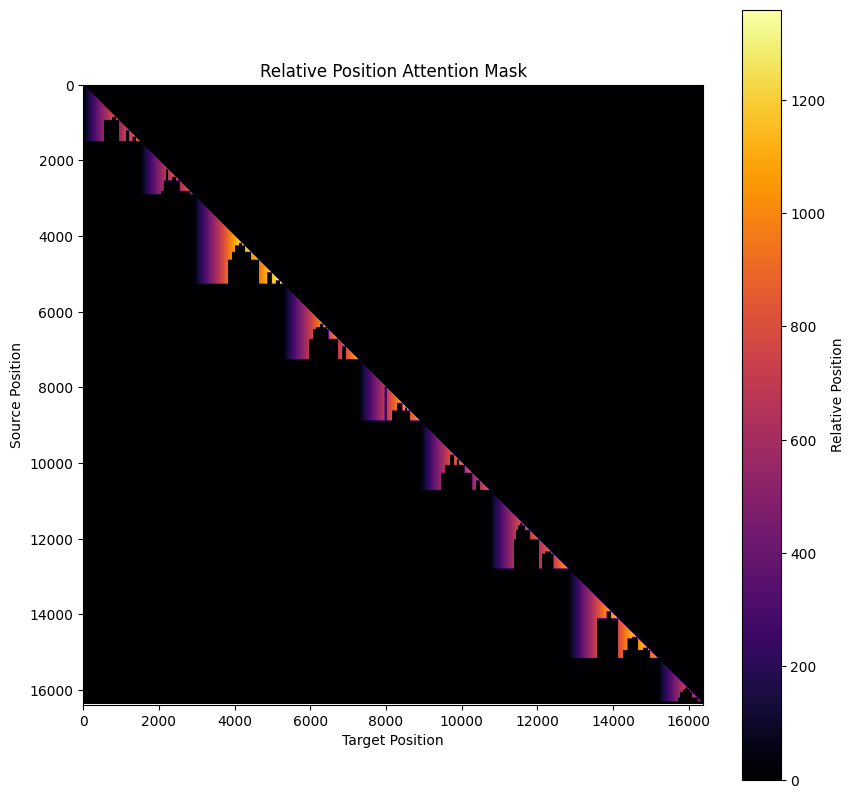

In [15]:
import matplotlib.pyplot as plt
import torch


def show(mask: torch.Tensor) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap="inferno")
    plt.colorbar(label="Relative Position")
    plt.title("Relative Position Attention Mask")
    plt.xlabel("Target Position")
    plt.ylabel("Source Position")
    plt.show()

i = 0
_tensors = result.tensors()
key = "input_pos"

show(
    _tensors["mask"][i].cumsum(dim=1)
    * (
        _tensors["mask"][i]
        & (
            ~torch.isnan(_tensors[key][i]).unsqueeze(0)
            & ~torch.isnan(_tensors[key][i]).unsqueeze(1)
        )
    )
)

In [6]:
result.tensors()["mask"].shape

torch.Size([128, 16384, 16384])

In [7]:
(tensors["mask"] == result.tensors()["mask"]).all()

tensor(True)

In [25]:
for i in range(127):
    for j in range(127):
        if (tensors["mask"][i] == result.tensors()["mask"][j]).all():
            print(i, j)

KeyboardInterrupt: 

In [13]:
key = "advantages"
torch.isclose(tensors[key], result.tensors()[key], rtol=1e-5, atol=1e-8, equal_nan=True).all()

tensor(True)

In [14]:
torch.all((tensors["weights"] == result.tensors()["weights"]))

tensor(True)

In [9]:
raise result.exceptions[1]

TypeError: only integer tensors of a single element can be converted to an index

In [6]:
result.exceptions

NameError: name 'result' is not defined

In [6]:
2_033_717 / 4.25

478521.64705882355

In [5]:
2_064_056 / 6.66

309918.3183183183

In [6]:
2_064_056 / 10.75

192005.2093023256

In [6]:
2_071_601 / 8

258950.125

In [7]:
2_071_601 / 11.75

176306.46808510637

In [5]:
4_119_041 / 16.5

249638.84848484848

In [4]:
await trainer.train(iterations=1)

$ vllm serve /home/ubuntu/atreides/experiments/models/rl/0003 --disable-log-requests --max-num-seqs=512 --scheduling-policy=priority --tensor-parallel-size=8 --port=8000 --api-key=default
INFO 11-24 02:30:57 api_server.py:528] vLLM API server version 0.6.3.post1
INFO 11-24 02:30:57 api_server.py:529] args: Namespace(subparser='serve', model_tag='/home/ubuntu/atreides/experiments/models/rl/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', model='/home/ubuntu/atreides/experiments/models/rl/0003', tokenizer=None, skip_tokeniz

(VllmWorkerProcess pid=55065) /home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/model_executor/model_loader/weight_utils.py:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

(VllmWorkerProcess pid=55067) INFO 11-24 02:31:45 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55064) INFO 11-24 02:31:45 model_runner.py:1067] Loading model weights took 1.8735 GB


Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.20s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.29s/it]



INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55061) INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55066) INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55065) INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55063) INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=55062) INFO 11-24 02:31:46 model_runner.py:1067] Loading model weights took 1.8735 GB
INFO 11-24 02:31:53 distributed_gpu_executor.py:57] # GPU blocks: 260871, # CPU blocks: 16384
INFO 11-24 02:31:53 distributed_gpu_executor.py:61] Maximum concurrency for 8192 tokens per request: 509.51x
(VllmWorkerProcess pid=55064) INFO 11-24 02:32:02 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not sta

INFO:     Started server process [54578]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8000) (Press CTRL+C to quit)


INFO:     127.0.0.1:37536 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/256 [00:00<?, ?episode/s]

explore:   0%|          | 0/256 [00:00<?, ?episode/s]

Packed sequences in 7.92s ✓
Prepared tensors in 18.11s ✓
Created mask in 29.57s ✓
$ tune run --nnodes=1 --nproc-per-node=8 lib.recipes.rl.RLRecipe --config /home/ubuntu/atreides/experiments/models/rl/config.yaml
Running with torchrun...


W1124 02:46:47.268000 125095847155520 torch/distributed/run.py:779] 
W1124 02:46:47.268000 125095847155520 torch/distributed/run.py:779] *****************************************
W1124 02:46:47.268000 125095847155520 torch/distributed/run.py:779] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1124 02:46:47.268000 125095847155520 torch/distributed/run.py:779] *****************************************
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 4
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/atreides/experiments/models/rl/0003
  checkpoint_files:
  - /home/ubuntu/atreides/experiments/models/rl/0003/hf_model_0002_0.pt
  - /home/ubuntu/atreides/experiments/models/rl/0003/hf_model_0003_0.pt
  - /hom

Writing logs to /home/ubuntu/atreides/experiments/models/rl/logs/log_1732416425.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 20.46 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.91 GiB
	GPU peak memory reserved: 3.03 GiB
	GPU peak memory active: 2.91 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/3 [00:00<?, ?it/s]/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/home/

Saved iteration 4 model files to /home/ubuntu/atreides/experiments/models/rl/0004
$ vllm serve /home/ubuntu/atreides/experiments/models/rl/0004 --disable-log-requests --max-num-seqs=512 --scheduling-policy=priority --tensor-parallel-size=8 --port=8000 --api-key=default
INFO 11-24 02:55:10 api_server.py:528] vLLM API server version 0.6.3.post1
INFO 11-24 02:55:10 api_server.py:529] args: Namespace(subparser='serve', model_tag='/home/ubuntu/atreides/experiments/models/rl/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', mode

(VllmWorkerProcess pid=64636) /home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/model_executor/model_loader/weight_utils.py:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

(VllmWorkerProcess pid=64641) INFO 11-24 02:55:58 model_runner.py:1067] Loading model weights took 1.8735 GB
INFO 11-24 02:55:58 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64636) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64640) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64639) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64638) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64642) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
(VllmWorkerProcess pid=64637) INFO 11-24 02:56:00 model_runner.py:1067] Loading model weights took 1.8735 GB
INFO 11-24 02:56:07 distributed_gpu_executor.py:57] # GPU blocks: 260871, # CPU blocks: 16384
INFO 11-24 02:56:07 distributed_gpu_executor.py:61] Maximum conc

INFO:     Started server process [64179]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8000) (Press CTRL+C to quit)


INFO:     127.0.0.1:58728 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/256 [00:00<?, ?episode/s]

In [4]:
val_score, episodes = await asyncio.gather(trainer.eval("val", 0), trainer.explore(1))

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --disable-log-requests --scheduling-policy=priority --tensor-parallel-size=2 --api-key=default
INFO 11-23 18:31:25 api_server.py:528] vLLM API server version 0.6.3.post1
INFO 11-23 18:31:25 api_server.py:529] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', model='NousResearch/Hermes-2-Theta-Llama-3-8B', tokenizer=None, skip_tokenizer_init=False, revision=None, code_revision=None, tokenizer_r

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.52it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.58it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  2.47it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.99it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.94it/s]



INFO 11-23 18:31:39 model_runner.py:1067] Loading model weights took 7.4829 GB
(VllmWorkerProcess pid=24769) INFO 11-23 18:31:39 model_runner.py:1067] Loading model weights took 7.4829 GB
INFO 11-23 18:31:40 distributed_gpu_executor.py:57] # GPU blocks: 61653, # CPU blocks: 4096
INFO 11-23 18:31:40 distributed_gpu_executor.py:61] Maximum concurrency for 8192 tokens per request: 120.42x
(VllmWorkerProcess pid=24769) INFO 11-23 18:31:42 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(VllmWorkerProcess pid=24769) INFO 11-23 18:31:42 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-23 18:31:42 model_runner

INFO:     Started server process [24430]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8000) (Press CTRL+C to quit)


INFO:     127.0.0.1:38090 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/32 [00:00<?, ?episode/s]

explore:   0%|          | 0/32 [00:00<?, ?episode/s]

In [18]:
from torchtune.models.llama3_1 import llama3_1_8b
from torchtune.training import cleanup_before_training
from torchtune.training.metric_logging import DiskLogger
from typing import Any

from lib.recipes.rl import ComponentConfig, RLConfig, RLRecipe
from lib.rl.pack import PackedDataset, packed_tensors_to_dir
from lib.rl.ppo import PPOLoss


tensors, checkpoint_dir, checkpoint_files = await trainer.tune_resources(episodes)

PLACEHOLDER: Any = None

config = RLConfig(
    # Dataset
    dataset=ComponentConfig(
        PackedDataset, **packed_tensors_to_dir(tensors, trainer.output_dir + "/tensors")
    ),
    seed=42,
    shuffle=False,
    # Model
    model=ComponentConfig(llama3_1_8b),
    num_output_chunks=4,
    # Checkpointer
    checkpointer=ComponentConfig(
        "torchtune.training.FullModelHFCheckpointer",
        checkpoint_dir=checkpoint_dir,
        checkpoint_files=checkpoint_files,
        recipe_checkpoint=None,
        output_dir=trainer.output_dir,
        model_type="LLAMA3",
    ),
    resume_from_checkpoint=False,
    # Fine-tuning arguments
    batch_size=4,
    epochs=1,
    optimizer=ComponentConfig(
        "torch.optim.AdamW",
        # "bitsandbytes.optim.PagedAdamW8bit",
        # "bitsandbytes.optim.AdamW",
        # params=PLACEHOLDER,
        lr=5e-6,
        fused=True,
    ),
    loss=ComponentConfig(
        PPOLoss,
        # clip_epsilon=0.3,
        # entropy_coef=0.0,
        # kl_coef=0.0,
        clip_epsilon=0.3,
        entropy_coef=0.025,
        kl_coef=0.025,
        normalize_advantages=False,
    ),
    max_steps_per_epoch=None,
    compile=False,
    optimizer_in_bwd=False,
    gradient_accumulation_steps=1,
    # Training env
    device="cuda",
    # Memory management
    enable_activation_checkpointing=True,
    enable_activation_offloading=False,
    custom_sharded_layers=["tok_embeddings", "output"],
    # Reduced precision
    dtype="bf16",
    # Logging
    metric_logger=ComponentConfig(
        DiskLogger, log_dir="/home/ubuntu/atreides/experiments/logs"
    ),
    log_every_n_steps=1,
    log_peak_memory_stats=True,
)

# recipe = RLRecipe(config)
# recipe.setup(config)
# recipe.train()
# recipe.cleanup()
# del tensors, recipe
# cleanup_before_training()
# trainer.save(base_checkpoint_dir=checkpoint_dir)

Packed sequences in 0.01s ✓
Prepared tensors in 0.35s ✓
Created mask in 0.65s ✓


In [19]:
from omegaconf import OmegaConf
dict_config = config.dict_config()
OmegaConf.save(dict_config, trainer.output_dir + "/config.yaml")

In [20]:
import os
import sys
from typing import IO

torchrun_kwargs = {"nnodes": 1, "nproc_per_node": 2}
kwargs = {}
env = {"CUDA_LAUNCH_BLOCKING": "1"}

args = [
    "tune",
    "run",
    *[
        f"--{key.replace('_', '-')}{f'={value}' if value is not True else ''}"
        for key, value in torchrun_kwargs.items()
    ],
    "lib.recipes.rl.RLRecipe",
    "--config",
    trainer.output_dir + "/config.yaml",
    *[
        f"--{key.replace('_', '-')}{f'={value}' if value != True else ''}"
        for key, value in kwargs.items()
    ],
]
print(f"$ {' '.join(args)}")

$ tune run --nnodes=1 --nproc-per-node=2 lib.recipes.rl.RLRecipe --config /home/ubuntu/atreides/experiments/models/rl/config.yaml


In [21]:
process = await asyncio.create_subprocess_exec(
    *args,
    stdout=asyncio.subprocess.PIPE,
    stderr=asyncio.subprocess.PIPE,
    env={
        **os.environ,
        **(env or {}),
    },
)


async def log_output(stream: asyncio.StreamReader, io: IO[str]) -> None:
    while True:
        line = await stream.readline()
        if not line:
            break
        decoded_line = line.decode()
        io.write(decoded_line)
        io.flush()


tasks = []
if process.stdout:
    tasks.append(asyncio.create_task(log_output(process.stdout, sys.stdout)))
if process.stderr:
    tasks.append(asyncio.create_task(log_output(process.stderr, sys.stderr)))
_ = await asyncio.gather(*tasks)

Running with torchrun...


W1123 18:47:25.110000 137426734001024 torch/distributed/run.py:779] 
W1123 18:47:25.110000 137426734001024 torch/distributed/run.py:779] *****************************************
W1123 18:47:25.110000 137426734001024 torch/distributed/run.py:779] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1123 18:47:25.110000 137426734001024 torch/distributed/run.py:779] *****************************************
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 4
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapsh

Writing logs to /home/ubuntu/atreides/experiments/logs/log_1732387649.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 4.42 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 8.47 GiB
	GPU peak memory reserved: 8.62 GiB
	GPU peak memory active: 8.47 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/home/u

In [6]:
from lib.recipes.rl import recipe_main
import os
from torch import distributed as dist
from torchtune.training import is_distributed

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29500"
os.environ["WORLD_SIZE"] = "1"
os.environ["RANK"] = "0"


recipe_main(config)

INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725/model-00003-of-00004.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725/model-00001-of-00004.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725/model-00004-of-00004.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725/model-

INFO:torchtune.utils._logging:Hint: enable_activation_checkpointing is True, but enable_activation_offloading isn't. Enabling activation offloading should reduce memory further.
DEBUG:torchtune.utils._logging:Setting manual seed to local seed 42. Local seed is seed + rank = 42 + 0


Writing logs to /home/ubuntu/atreides/experiments/logs/log_1732386575.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 3.00 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.89 GiB
	GPU peak memory reserved: 15.99 GiB
	GPU peak memory active: 15.89 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
1|1|

RuntimeError: No backend type associated with device type cpu

In [7]:
from omegaconf import DictConfig, OmegaConf
dict_config = config.dict_config()
OmegaConf.save(dict_config, trainer.output_dir + "/config.yaml")

In [26]:
from lib.rl.completion import Completion


OmegaConf.create(OmegaConf.to_yaml(DictConfig(dict(name=f"{Completion.__module__}.{Completion.__name__}"))))

{'name': 'lib.rl.completion.Completion'}

In [27]:
import traceback
import sys

traceback.clear_frames(sys.exc_info()[2])

In [28]:
cleanup_before_training()

In [29]:
trainer.save(base_checkpoint_dir=checkpoint_dir)

No model checkpoint files found to save in output directory /home/ubuntu/atreides/experiments/models/rl


In [30]:
import matplotlib.pyplot as plt
import torch


def show(mask: torch.Tensor) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap="inferno")
    plt.colorbar(label="Relative Position")
    plt.title("Relative Position Attention Mask")
    plt.xlabel("Target Position")
    plt.ylabel("Source Position")
    plt.show()

i = 1

show(
    tensors["mask"][i].cumsum(dim=1)
    * (
        tensors["mask"][i]
        & (
            ~torch.isnan(tensors["advantages"][i]).unsqueeze(0)
            & ~torch.isnan(tensors["advantages"][i]).unsqueeze(1)
        )
    )
)

NameError: name 'tensors' is not defined

In [ ]:
from IPython.display import HTML

HTML(
    f'<div style="white-space: pre-wrap">{list(episodes[2].completion.leaves())[0].html(30.0)}</div>'
)

In [ ]:
def mask_and_pos_ids(
    ids: torch.Tensor, parent_ids: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    """Creates an attention mask and position IDs for hierarchical attention based on node IDs and their parent IDs.

    Args:
        ids: A tensor of shape (batch_size, sequence_length) containing node IDs
        parent_ids: A tensor of shape (batch_size, sequence_length) containing parent IDs for each node

    Returns:
        A tuple containing:
        - mask: A boolean tensor of shape (batch_size, sequence_length, sequence_length) where True indicates
          allowed attention connections. Each position can attend to itself and any of its ancestors
          in the hierarchy, but only for previous positions (due to causal masking).
        - pos_ids: A tensor of shape (batch_size, sequence_length, sequence_length) containing relative
          position IDs for each allowed attention connection, with -1 for masked positions.
    """
    mask = ids.unsqueeze(1) == ids.unsqueeze(2)
    _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    while torch.any(mask != _mask):
        parent_ids = parent_ids.gather(
            1, torch.argmax((parent_ids.unsqueeze(2) == ids.unsqueeze(1)).int(), dim=2)
        )
        mask = _mask
        _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    mask &= torch.tril(torch.ones_like(mask, dtype=torch.bool, device=ids.device))
    # mask = torch.linalg.matrix_power(mask.float(), mask.size(1) - 1) > 0
    pos_ids = (torch.where(mask, mask.cumsum(2), 0) - 1).max(1).values
    return mask, pos_ids


def test_mask_and_pos_ids(
    ids: list[int],
    parent_ids: list[int],
    expected_mask: list[list[int]],
    expected_pos_ids: list[int],
):
    mask, pos_ids = mask_and_pos_ids(
        ids=torch.tensor([ids]), parent_ids=torch.tensor([parent_ids])
    )
    assert torch.all(mask.int() == torch.tensor([expected_mask])), f"\n{mask.int()[0]}"
    assert torch.all(
        pos_ids == torch.tensor([expected_pos_ids])
    ), f"{pos_ids[0].tolist()}"


test_mask_and_pos_ids(
    ids=[0, 1],
    parent_ids=[0, 1],
    expected_mask=[[1, 0], [0, 1]],
    expected_pos_ids=[0, 0],
)

test_mask_and_pos_ids(
    ids=[0, 1, 1],
    parent_ids=[0, 0, 0],
    expected_mask=[[1, 0, 0], [1, 1, 0], [1, 1, 1]],
    expected_pos_ids=[0, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 0, 1, 2],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]],
    expected_pos_ids=[0, 1, 2, 3],
)

test_mask_and_pos_ids(
    ids=[0, 0, 1, 1],
    parent_ids=[0, 0, 1, 1],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 1]],
    expected_pos_ids=[0, 1, 0, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 1, 0, 1],
    expected_mask=[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1]],
    expected_pos_ids=[0, 0, 1, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 2, 3, 3],
    parent_ids=[0, 1, 0, 0, 1, 1],
    expected_mask=[
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 0, 1, 2, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3, 4, 4, 5, 5],
    parent_ids=[0, 0, 1, 1, 2, 2, 3, 3],
    expected_mask=[
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 1, 2, 2, 3, 4, 3, 4],
)

test_mask_and_pos_ids(
    ids=[2, 1, 0],
    parent_ids=[2, 2, 0],
    expected_mask=[
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
    ],
    expected_pos_ids=[0, 1, 0],
)